In [20]:
##FINAL VERSION:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def split_dataset(input_folder, output_folder):
    stance_data = []
    swing_data = []
    
    # Recursively load and separate stance/swing data from subdirectories
    for root, dirs, files in os.walk(input_folder):
        for file_name in files:
            if file_name.endswith('.csv'):
                file_path = os.path.join(root, file_name)
                print(f"Processing file: {file_name} in folder: {root}")  # Debugging line
                df = pd.read_csv(file_path)
                if 'stance' in file_name:
                    stance_data.append((df, file_name))
                elif 'swing' in file_name:
                    swing_data.append((df, file_name))
    
    print(f"Stance data count: {len(stance_data)}")  # Debugging line
    print(f"Swing data count: {len(swing_data)}")  # Debugging line

    if not stance_data or not swing_data:
        print("No stance or swing data found! Check your input folder.")
        return

    # Create train-test split for stance
    stance_train, stance_test = train_test_split(stance_data, test_size=0.15, random_state=42)
    save_split(stance_train, os.path.join(output_folder, 'stance/train'))
    save_split(stance_test, os.path.join(output_folder, 'stance/test'))

    # Create train-test split for swing
    swing_train, swing_test = train_test_split(swing_data, test_size=0.15, random_state=42)
    save_split(swing_train, os.path.join(output_folder, 'swing/train'))
    save_split(swing_test, os.path.join(output_folder, 'swing/test'))


# Helper function to save split datasets
def save_split(data_split, folder):
    os.makedirs(folder, exist_ok=True)
    for df, file_name in data_split:
        df.to_csv(os.path.join(folder, file_name), index=False)

# Function to train Isolation Forest models
def train_isolation_forests(training_folder):
    stance_folder = os.path.join(training_folder, 'stance/train')
    swing_folder = os.path.join(training_folder, 'swing/train')
    
    # Prepare stance data
    stance_features = []
    for file_name in os.listdir(stance_folder):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(stance_folder, file_name))
            stance_features.append(df.drop(columns=['label'], errors='ignore').values)
    stance_features = np.vstack(stance_features)

    # Train stance model
    stance_model = IsolationForest(contamination=0.1, random_state=42, n_estimators=200)
    stance_model.fit(stance_features)
    
    # Prepare swing data
    swing_features = []
    for file_name in os.listdir(swing_folder):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(swing_folder, file_name))
            swing_features.append(df.drop(columns=['label'], errors='ignore').values)
    swing_features = np.vstack(swing_features)

    # Train swing model
    swing_model = IsolationForest(contamination=0.1, random_state=42, n_estimators=200)
    swing_model.fit(swing_features)
    
    return stance_model, swing_model

# Function to test Isolation Forest models and save predictions
def test_isolation_forests(stance_model, swing_model, testing_folder):
    stance_folder = os.path.join(testing_folder, 'stance/test')
    swing_folder = os.path.join(testing_folder, 'swing/test')

    # Test stance model
    process_and_predict(stance_model, stance_folder)

    # Test swing model
    process_and_predict(swing_model, swing_folder)

# Helper function to process and predict
def process_and_predict(model, folder):
    for file_name in os.listdir(folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder, file_name)
            df = pd.read_csv(file_path)
            features = df.drop(columns=['label'], errors='ignore').values

            # Predict using the model
            predictions = model.predict(features)
            # Convert predictions to 0 (normal) and 1 (abnormal)
            df['Predicted_Label'] = [0 if p == 1 else 1 for p in predictions]

            # Save updated CSV
            df.to_csv(file_path, index=False)

In [21]:
# Example usage
input_folder = r"C:\Users\diyav\.jupyter\Labeled Data"  # Folder with raw CSVs
output_folder = r"C:\Users\diyav\.jupyter\Split Data"  # Folder for split datasets

# Step 1: Split the dataset into train/test
split_dataset(input_folder, output_folder)

# Step 2: Train separate Isolation Forest models
stance_model, swing_model = train_isolation_forests(output_folder)

# Step 3: Test models and save predictions
test_isolation_forests(stance_model, swing_model, output_folder)

# Step 4 (Optional): Evaluate results
# Load testing data and calculate classification metrics
true_labels, predicted_labels = [], []
test_folders = [os.path.join(output_folder, 'stance/test'), os.path.join(output_folder, 'swing/test')]

for folder in test_folders:
    for file_name in os.listdir(folder):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, file_name))
            true_labels.extend(df['label'])
            predicted_labels.extend(df['Predicted_Label'])

# Print evaluation metrics
print(classification_report(true_labels, predicted_labels))

Processing file: stance_features_1.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_10.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_11.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_2.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_3.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_4.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_5.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_6.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_7.csv in folder: C:\Users\diyav\.jupyter\Labeled Data\sub10_2_normal
Processing file: stance_features_8.csv in folder: C:\Users\diyav\.jupyter\Labele

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Confusion Matrix:
 [[17  3]
 [ 4  0]]


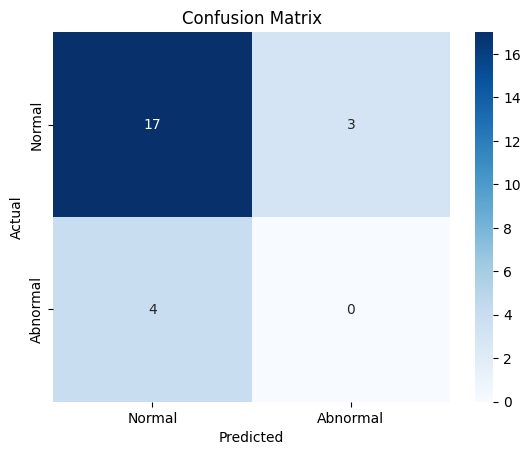

In [19]:
# Assuming `true_labels` and `predicted_labels` are already defined
y_true = true_labels  # Actual labels
y_pred = predicted_labels  # Predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()